# Discovering hidden factors of variation in deep networks 

This is based on https://github.com/Lasagne/Lasagne/blob/highway_example/examples/Hidden%20factors.ipynb but using Tensorflow 2.0. 


In [1]:
%matplotlib inline

In [2]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(np.__version__)
print(tf.__version__)

1.16.2
2.0.0-alpha0


In [4]:
# Set random seed
tf.random.set_seed(1)

## Loading data

In [5]:
print("Loading data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the dataset
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

batch_size = 256

# Create the training database iterator
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.batch(batch_size)

Loading data...


## Building model


We will define the model listed in Table 1 in the paper.

This model has an encoder with two ReLU layers. They both have 500 units. On top of the encoder are two representation layers: one is a 10-way softmax layer which represents the class of the input. This is the observed representation layer. Then there is also a latent representation layer which has two additional linear units (the authors use only two units for easy visualization).

Both representation layers are concatenated and the decoder is stacked on top. This consists of three layers: two hidden ReLU layers with again 500 units, and finally a reconstruction layer with 784 outputs.


In [6]:
# Building model
n_class = 10
input_dim = 784
z_dim = 2


# Encoder
def make_encoder_model():
    inputs = tf.keras.Input(shape=(input_dim,), name='Original_input')
    x = tf.keras.layers.Dense(500, activation='relu')(inputs)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    latent = tf.keras.layers.Dense(z_dim, activation='linear', name='Latent_variables')(x)
    observed = tf.keras.layers.Dense(n_class, activation='softmax', name='Observed_variables')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[latent, observed], name='Encoder')
    return model


encoder = make_encoder_model()

In [7]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Original_input (InputLayer)     [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 500)          392500      Original_input[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          250500      dense[0][0]                      
__________________________________________________________________________________________________
Latent_variables (Dense)        (None, 2)            1002        dense_1[0][0]                    
____________________________________________________________________________________________

In [8]:
# Decoder
def make_decoder_model():
    inputted_latent = tf.keras.Input(shape=(z_dim,), name='Latent_variables')
    inputted_observed = tf.keras.Input(shape=(n_class,), name='Observed_variables')

    x = tf.keras.layers.concatenate([inputted_latent, inputted_observed], axis=-1)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    reconstruction = tf.keras.layers.Dense(input_dim, activation='linear', name='Reconstruction')(x)
    model = tf.keras.Model(inputs=[inputted_latent, inputted_observed], outputs=reconstruction, name='Decoder')
    return model


decoder = make_decoder_model()

In [9]:
decoder.summary()

Model: "Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_variables (InputLayer)   [(None, 2)]          0                                            
__________________________________________________________________________________________________
Observed_variables (InputLayer) [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12)           0           Latent_variables[0][0]           
                                                                 Observed_variables[0][0]         
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 500)          6500        concatenate[0][0]          

## Loss function
Next, we'll define the loss functions. This consists of three parts: alpha * reconstruction cost + beta * supervised cost + gamma * unsupervised cross-covariance (XCov) cost (formula 3 in the paper). XCov cost disentangles the observed and latent variables of the encoder.

In [10]:
# Multipliers
alpha = 1.0
beta = 10.0
gamma = 10.0

# Loss functions
# Reconstruction cost
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Supervised cost
cat_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [11]:
# Unsupervised cross-covariance cost
def xcov_loss_fn(latent, observed, batch_size):
    latent_centered = latent - tf.reduce_mean(latent, axis=0, keepdims=True)
    observed_centered = observed - tf.reduce_mean(observed, axis=0, keepdims=True)
    xcov_loss = 0.5 * tf.reduce_sum(
        tf.square(tf.matmul(latent_centered, observed_centered, transpose_a=True) / batch_size))

    return xcov_loss

## Optimizer

In [12]:
optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)

## Training function

In [13]:
# Training step
@tf.function
def train_on_batch(batch_x, batch_y):
    with tf.GradientTape() as tape:
        # Inference
        batch_latent, batch_observed = encoder(batch_x)
        batch_reconstruction = decoder([batch_latent, batch_observed])

        # Loss functions
        recon_loss = alpha * mse_loss_fn(batch_x, batch_reconstruction)
        cat_loss = beta * cat_loss_fn(tf.one_hot(batch_y, n_class), batch_observed)
        xcov_loss = gamma * xcov_loss_fn(batch_latent, batch_observed, tf.cast(tf.shape(batch_x)[0], tf.float32))

        # Final loss function
        ae_loss = recon_loss + cat_loss + xcov_loss

    gradients = tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return recon_loss, cat_loss, xcov_loss

## Training loop


Now let's tie everything together in the main training loop.

In [14]:
n_epochs = 200
for epoch in range(n_epochs):
    start = time.time()

    # Functions to calculate epoch's mean performance
    epoch_recon_loss_avg = tf.metrics.Mean()
    epoch_cat_loss_avg = tf.metrics.Mean()
    epoch_xcov_loss_avg = tf.metrics.Mean()

    for batch, (batch_x, batch_y) in enumerate(train_dataset):
        recon_loss, cat_loss, xcov_loss = train_on_batch(batch_x, batch_y)

        epoch_recon_loss_avg(recon_loss)
        epoch_cat_loss_avg(cat_loss)
        epoch_xcov_loss_avg(xcov_loss)

    epoch_time = time.time() - start
    print('{:3d}: {:.2f}s ETA: {:.2f}s  Reconstruction cost: {:.4f}  Supervised cost: {:.4f}  XCov cost: {:.4f}'
          .format(epoch + 1, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_recon_loss_avg.result(),
                  epoch_cat_loss_avg.result(),
                  epoch_xcov_loss_avg.result()))

  1: 3.46s ETA: 691.34s  Reconstruction cost: 0.0799  Supervised cost: 3.0308  XCov cost: 0.0404
  2: 1.35s ETA: 269.63s  Reconstruction cost: 0.0647  Supervised cost: 0.9440  XCov cost: 0.0260
  3: 1.39s ETA: 274.79s  Reconstruction cost: 0.0626  Supervised cost: 0.5367  XCov cost: 0.0221
  4: 1.37s ETA: 270.10s  Reconstruction cost: 0.0601  Supervised cost: 0.3464  XCov cost: 0.0187
  5: 1.37s ETA: 269.31s  Reconstruction cost: 0.0578  Supervised cost: 0.2248  XCov cost: 0.0182
  6: 1.34s ETA: 261.57s  Reconstruction cost: 0.0561  Supervised cost: 0.1540  XCov cost: 0.0185
  7: 1.37s ETA: 266.60s  Reconstruction cost: 0.0551  Supervised cost: 0.1114  XCov cost: 0.0161
  8: 1.39s ETA: 267.51s  Reconstruction cost: 0.0545  Supervised cost: 0.0967  XCov cost: 0.0152
  9: 1.35s ETA: 258.49s  Reconstruction cost: 0.0541  Supervised cost: 0.0581  XCov cost: 0.0146
 10: 1.36s ETA: 260.18s  Reconstruction cost: 0.0538  Supervised cost: 0.0427  XCov cost: 0.0138
 11: 1.34s ETA: 255.12s  Recon

 86: 1.34s ETA: 153.97s  Reconstruction cost: 0.0410  Supervised cost: 0.0003  XCov cost: 0.0017
 87: 1.40s ETA: 159.15s  Reconstruction cost: 0.0409  Supervised cost: 0.0003  XCov cost: 0.0017
 88: 1.41s ETA: 159.16s  Reconstruction cost: 0.0409  Supervised cost: 0.0002  XCov cost: 0.0017
 89: 1.40s ETA: 156.37s  Reconstruction cost: 0.0408  Supervised cost: 0.0002  XCov cost: 0.0016
 90: 1.38s ETA: 152.85s  Reconstruction cost: 0.0407  Supervised cost: 0.0002  XCov cost: 0.0016
 91: 1.33s ETA: 145.76s  Reconstruction cost: 0.0407  Supervised cost: 0.0002  XCov cost: 0.0016
 92: 1.35s ETA: 146.71s  Reconstruction cost: 0.0406  Supervised cost: 0.0002  XCov cost: 0.0016
 93: 1.34s ETA: 144.75s  Reconstruction cost: 0.0406  Supervised cost: 0.0002  XCov cost: 0.0016
 94: 1.38s ETA: 147.33s  Reconstruction cost: 0.0405  Supervised cost: 0.0002  XCov cost: 0.0015
 95: 1.41s ETA: 149.75s  Reconstruction cost: 0.0404  Supervised cost: 0.0002  XCov cost: 0.0015
 96: 1.40s ETA: 146.66s  Recon

171: 1.38s ETA: 41.35s  Reconstruction cost: 0.0377  Supervised cost: 0.0001  XCov cost: 0.0009
172: 1.39s ETA: 40.20s  Reconstruction cost: 0.0377  Supervised cost: 0.0001  XCov cost: 0.0009
173: 1.36s ETA: 37.96s  Reconstruction cost: 0.0377  Supervised cost: 0.0001  XCov cost: 0.0009
174: 1.36s ETA: 36.67s  Reconstruction cost: 0.0376  Supervised cost: 0.0001  XCov cost: 0.0009
175: 1.38s ETA: 35.99s  Reconstruction cost: 0.0376  Supervised cost: 0.0001  XCov cost: 0.0009
176: 1.35s ETA: 33.69s  Reconstruction cost: 0.0376  Supervised cost: 0.0001  XCov cost: 0.0009
177: 1.33s ETA: 31.95s  Reconstruction cost: 0.0376  Supervised cost: 0.0001  XCov cost: 0.0009
178: 1.33s ETA: 30.70s  Reconstruction cost: 0.0375  Supervised cost: 0.0001  XCov cost: 0.0009
179: 1.35s ETA: 29.76s  Reconstruction cost: 0.0375  Supervised cost: 0.0001  XCov cost: 0.0009
180: 1.35s ETA: 28.28s  Reconstruction cost: 0.0375  Supervised cost: 0.0001  XCov cost: 0.0009
181: 1.34s ETA: 26.72s  Reconstruction c

## Test set performance

In [15]:
acc_fn = tf.keras.metrics.CategoricalAccuracy()

z_test, observed_test = encoder(x_test)
acc_test = acc_fn(tf.one_hot(y_test, n_class), observed_test)

print('Test set accuracy: {:.2f}'.format(100 * acc_test))

Test set accuracy: 98.67


## Visualizating latent space

Now let's computes the latent representation variables z so we can visualize them on the test set.

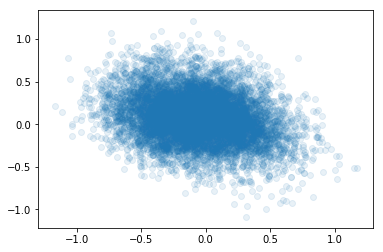

In [16]:
# Figure 3a
plt.figure()
plt.scatter(z_test.numpy()[:, 0], z_test.numpy()[:, 1], alpha=0.1)
plt.show()

Our latent variables have a smaller magnitude overall, but exhibit a roughly Gaussian distribution just like in the paper.

## Sampling latent space

Now let's generate some reconstructions.

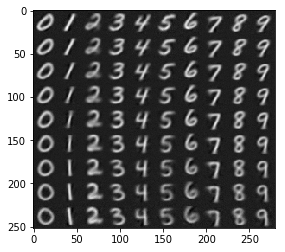

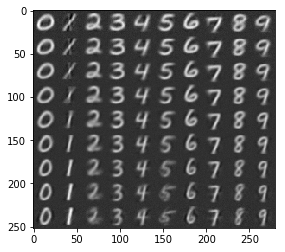

In [17]:

# Figure 3b and c
ys = np.repeat(np.arange(10), 9).astype('int32')
zs = np.tile(np.linspace(-0.5, 0.5, 9), 10).astype('float32')
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

reconstructions_z1 = decoder([z1s, tf.one_hot(ys, n_class)]).numpy()
reconstructions_z2 = decoder([z2s, tf.one_hot(ys, n_class)]).numpy()

im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()
